# q3dfit example notebook: rest-frame mid-IR, Spitzer IRS data of 2MASX J15561599+3951374, a.k.a. IRAS F15545+4000.

<h3><font color='teal'>Installation of the environment and the package are described <a href="https://q3dfit.readthedocs.io/">here</a>. </font></h3>

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.0. Setting up the directory tree](#chapter1_0)
    * [1.1. Initializing the fit](#chapter1_1)
    * [1.2. Setting up the data and models](#chapter1_2)
    * [1.3. Setting up the fitting parameters](#chapter1_3)
        * [1.3.1. Emission line parameters](#chapter1_3_1)
        * [1.3.2. Continuum parameters](#chapter1_3_2)
* [2. Run fitting](#chapter2)
* [3. Plot fit](#chapter3)
* [4. Combine fit results for entire cube](#chapter4)
* [5. Map fit results](#chapter5)

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Be sure to set the path to q3dfit correctly.
# For instance:
#import sys
#sys.path.append('/Users/jwstuser/q3dfit/')
#import sys
#sys.path.append("../")

### 1.0. Setting up the directory tree <a class="anchor" id="chapter1_0"></a>

Define the directories in which the data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from q3dfit will be saved. Then download test data.

In [3]:
# Base directory (book-keeping)
volume = 'Spitzer-example/'
# prefix label for output files
label = 'j1556'
# Input directory
indir = volume
if not os.path.exists(indir):
    os.makedirs(indir)
# Output directory
outdir = volume
if not os.path.exists(outdir):
    os.makedirs(outdir)
# Initialization file (q3di.npy) directory
initdir = volume
# Output logfile
logfile = outdir+label+'-fitlog.txt'

Download data from public Box folder. <font color='red'> Note: This also downloads the *.cf configuration file (specifying which spectral components to include in the MIR fitting). We note that the format of this file is currently under development and it will in the future be superseded by a more readable/convenient option. For a current description of continuum fitting parameters in the .cf file, please see the documentation: 
https://q3dfit.readthedocs.io/en/latest/

In [4]:
# make tuples of urls and download filenames
# infile = 1x1 mock data cube: containing only 1 single spaxel with a Spitzer spectrum
# cf = config file
infile_tup = ('https://rhodes.box.com/shared/static/spe9pc4kbwylw2khwcca0cimoaks6puh.fits', '22128896_mock_cube.fits')
cf_tup = ('https://rhodes.box.com/shared/static/6502fu97kxwky9zl5t2t8gnn6n2fi2y9.cf', '22128896.cf')
# download files; by default don't force overwrite and take first element of output
from q3dfit.jnb import download_files
infile = download_files(infile_tup, indir, force=False)[0]
cfinfile = download_files(cf_tup, indir, force=False)[0]
# add subdirectory to filenames
infile = indir+infile
cfinfile = indir+cfinfile

22128896_mock_cube.fits already exists, skipping download...
22128896.cf already exists, skipping download...


### 1.1. Initializing the fit <a class="anchor" id="chapter1_1"></a>

The initial parameters of the fit are stored in an object of class `q3din`. Each parameter or attribute of this class controls some aspect of the fit process. We start by instantiating the class. The only required parameters at the outset are the input data cube and label; the label is used for output file naming. 

The default JWST pipeline output has data, variance, and data quality in extensions 1, 2, and 3, respectively. Our processed cube has a different set of extensions, so we specify them here.

In [5]:
from q3dfit.q3din import q3din
q3di = q3din(infile, label, outdir=outdir, logfile=logfile)

Here's a list of the fit parameters that are automatically set:

In [6]:
q3di.__dict__

{'argsreadcube': {},
 'cutrange': None,
 'infile': 'Spitzer-example/22128896_mock_cube.fits',
 'fitrange': None,
 'label': 'j1556',
 'logfile': 'Spitzer-example/j1556-fitlog.txt',
 'name': None,
 'outdir': 'Spitzer-example/',
 'spect_convol': {},
 'vacuum': True,
 'zsys_gas': None,
 'datext': 1,
 'varext': 2,
 'dqext': 3,
 'vormap': None,
 'docontfit': False,
 'dolinefit': False}

### 1.2. Setting up the data and models <a class="anchor" id="chapter1_2"></a>

Some general information about your cube. `argsreadcube` is a dictionary of attributes sent to the `Cube` class.
- For non-JWST data, set `wmapext` to `None`. The WMAP extension is a [3-D weight image](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html) giving the relative weights of the output spaxels. While our data is from JWST, the wmap extension has been cut out during processing.
- Microns are the wavelength unit used internally, but `q3dfit` can accept input/output in Å.
- `q3dit` does calculations in f$_\lambda$ space, but assumes input units of MJy/sr, the JWST default. Other input wavelength units can be specified. In this case, the reduced data has been converted to erg/s/cm$^2$/Å. The output flux units will be in erg/s/cm$^2$/$\mu$m.



Some general information about your cube:

In [7]:
from q3dfit.readcube import Cube
q3di.argsreadcube = {'wmapext': None,
                     'wavext': 4,
                     'waveunit_in': 'Angstrom',
                     'fluxunit_in': 'Jy'}
cube = q3di.load_cube()

#if not os.path.isfile(cfinfile):
#    print('Configuration file not found.')
#else:
#    config_file = readcf(cfinfile)

Size of data cube: [ 1 , 1 , 360 ]
Wavelength range: [ 4.8986106 , 34.87191 ]  micron


Let's plot the spectrum to see how it looks. The arguments are column and row in unity-offset units. 

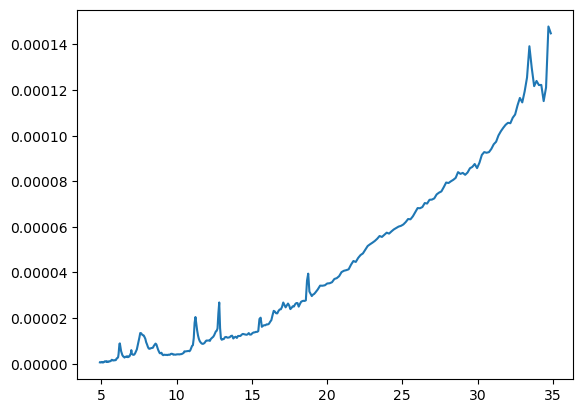

In [8]:
spec_test = cube.specextract(1,1, radius=0)

Name and systemic redshift of the galaxy. `zsys_gas` is an input for calculating velocity maps in `q3dpro` and for initializing the arrays of initial guesses below. In this case, the spectrum has already been shifted to the rest frame.

In [9]:
q3di.name = 'F15545+4000'
q3di.zsys_gas = 0.0

Wavelength range over which to fit data. The user can also specify sets of regions to ignore in the fit.

In [10]:
q3di.fitrange = np.array([5.42, 29.98])  # micron
#q3di.cutrange = np.array([,])

### 1.3. Setting up the fitting parameters <a class="anchor" id="chapter1_3"></a>

#### 1.3.1. Emission-line parameters <a class="anchor" id="chapter1_3_1"></a>

What lines do you want to fit? You can choose from the linelists [here](https://github.com/Q3D/q3dfit/tree/main/data/linelists), or in `q3dfit/data/linelists/`.

In [11]:
lines = ['H2_00_S5', '[ArII]6.99', '[ArIII]8.99', '[NeII]12.81', 
         '[NeIII]15.56', 'H2_00_S3', 'H2_00_S1', '[SIII]18.71']

This block sets up initial conditions for the emission-line fit to each spaxel. This initialization method adds a number of new attributes to the object. Emission lines are set to a common redshift and velocity dispersion, set to `q3di.zsys_gas` and 50 km/s by default. However, different sets of emission lines can have different velocities and linewidths by specifying different lines to which to tie particular emission lines. Different initial conditions can also be set on a spaxel-by-spaxel and/or line-by-line basis. The default number of velocity components is 1.

In [12]:
q3di.init_linefit(lines, linetie='[NeII]12.81')
q3di.__dict__.keys()

dict_keys(['argsreadcube', 'cutrange', 'infile', 'fitrange', 'label', 'logfile', 'name', 'outdir', 'spect_convol', 'vacuum', 'zsys_gas', 'datext', 'varext', 'dqext', 'vormap', 'docontfit', 'dolinefit', 'ncols', 'nrows', 'cubedim', 'lines', 'argscheckcomp', 'argslineinit', 'argslinefit', 'argslinelist', 'checkcomp', 'fcncheckcomp', 'fcnlineinit', 'maxncomp', 'peakinit', 'siglim_gas', 'linetie', 'ncomp', 'siginit_gas', 'zinit_gas'])

Because these lines are not well-resolved spectrally, we change the default initial conditions in sigma.

In [13]:
for i in lines:
    q3di.siginit_gas[i][:,:,0] = 1000.

`siglim_gas` sets lower and upper bounds for the Gaussian width (sigma) of the emission line. These limits can be set globablly, for all spaxels and components, by defining a 2-element array. The limits can also be set for individual spaxels (but all components) by defining an (Ncol x Nrow x 2) array.

In [14]:
q3di.siglim_gas = np.array([5., 4000.])

# Spaxel-by-spaxel limit
# siglim_gas = np.ndarray((dx, dy, 2))
# siglim_gas[:,:,] = array([5.,1000.])
# siglim_gas[13, 10, :] = array([5.,500.])

The routine `checkcomp` automatically discards components that it deems insignificant after each fit. It does so with both a significance cut on flux, and if the linewidth is too large. If components are removed, the fit is re-run. The `sigcut` parameter determines the level of the significance cut. `ignore` is a list of lines to ignore when performing the significance cut. Component checking can be disabled by setting `checkcomp = False`.

In [15]:
q3di.checkcomp = False
#q3di.argscheckcomp['sigcut'] = 3.
#q3di.argscheckcomp['ignore']= ['H2_00_S5']

#### Spectral resolution convolution
##### Just running convolution ---

If no convolution is desired, then set `spectres_convolve` to None. 
If convolution is desired, then `spectres_convolve` and `spect_instrum` are required variables.

Specify the desired convolution method using `spect_instrum`. The syntax is: 
`spect_instrum = {INSTRUMENT:[METHOD]}`, which should mirror the filename in `q3dfit/data/dispersion_files/`. METHOD specifies the grating, spectral resolution [R], Δλ FWHM in [Å], velocity in [km/s].

Examples convolving with: 
1. flat R=500: `spect_instrum = {'flat':['R500']}`
2. flat velocity FWHM = 30km/s: `spect_instrum = {'flat':['kms30']}`
3. flat Δλ FWHM = 4 Å: `spect_instrum = {'flat':['dlambda4']}`
4. JWST NIRSPEC / G140M: `spect_instrum = {'JWST_NIRSPEC':['G140M']}`

If desired flat convolution file does not exist, then a new file will be created automatically. 

In [16]:
spect_instrum = {'spitzer_irs_ch0':['sl2','sl1',],'spitzer_irs_ch2':['ll1','ll2']}
q3di.spect_convol['ws_instrum'] = spect_instrum

##### Creating convolution files (optional) ---

If the user wants to create a dispersion file, there are 2 methods:

1. First, run `from q3dfit.spectConvol import dispFile` and initialize: `dispObj = dispFile()`
2. Create the files with either method A or B

2.(A) Create a flat R=120 dispersion file from 10 μm to 30 μm: 

`dispObj.make_dispersion(120,WAVELEN=[10,30],TYPE='R')`

2.(B) Create a custom dispersion file with user supplied wavelength and Resolving power lists:

`dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')`

3. Specify desired dispersion file in convolution: running custom example 2B

`spect_instrum = {'custom':['RlistA']}`


In [17]:
#from q3dfit.spectConvol import dispFile
#dobj = dispFile()
#dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')
#spect_instrum = {'custom':['RlistA']}

#### Options to `lmfit` and `scipy.optimize.least_squares`
`q3dfit` uses the `fit` method of the [`Model` class](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model) of `lmfit` to call [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html). Both the method and function have options which can be changed in the `q3dfit` call. To do so, add key/value pairs to the `argslinefit` dictionary, which in turn is a keyword of the `q3di` dictionary.

The options to the `fit` method in `lmfit` that can currently be changed are the following:
- `max_nfev`: maximum number of function evaluations before the fit aborts
- `iter_cb`: if this is set to "per_iteration", the value of every model parameter at each function evaluation is printed to `stdout`

Most parameters of `least_squares` can be changed in this way, unless they are specifically set by `lmfit`. Examples which have been tested include:
- `x_scale`: jac
- `tr_solver`: lsmr
- `loss`: soft_l1
- `ftol`, `gtol`, `xtol`

In [18]:
#q3di.argslinefit['iter_cb'] = 'per_iteration'
# As an example, to change the criteria for fit convergence from the defaults of 1.e-8 to 1.e-10:
q3di.argslinefit['ftol'] = 1.e-10
q3di.argslinefit['gtol'] = 1.e-10
q3di.argslinefit['xtol'] = 1.e-10

#### 1.3.2 Continuum parameters <a class="anchor" id="chapter1_3_2"></a>

We next initialize the continuum. As part of this, we give it the name of our continuum fitting function. (See Rupke et al. 2017 for more details on the methodology of `q3dfit` when separating a quasar from its host galaxy.)

In [19]:
q3di.init_contfit('questfit')
q3di.__dict__.keys()

dict_keys(['argsreadcube', 'cutrange', 'infile', 'fitrange', 'label', 'logfile', 'name', 'outdir', 'spect_convol', 'vacuum', 'zsys_gas', 'datext', 'varext', 'dqext', 'vormap', 'docontfit', 'dolinefit', 'ncols', 'nrows', 'cubedim', 'lines', 'argscheckcomp', 'argslineinit', 'argslinefit', 'argslinelist', 'checkcomp', 'fcncheckcomp', 'fcnlineinit', 'maxncomp', 'peakinit', 'siglim_gas', 'linetie', 'ncomp', 'siginit_gas', 'zinit_gas', 'fcncontfit', 'argscontfit', 'argsconvtemp', 'decompose_qso_fit', 'decompose_ppxf_fit', 'dividecont', 'ebv_star', 'fcnconvtemp', 'forcefloat64', 'keepstarz', 'maskwidths', 'maskwidths_def', 'masksig_secondfit', 'nolinemask', 'nomaskran', 'startempfile', 'startempvac', 'tweakcntfit', 'siginit_stars', 'zinit_stars'])

`q3dfit` first masks emission lines before fitting. This sets is the default mask value in km/s for each velocity component for the first fit. During the second fit, the mask value is set automatically using the best-fit linewidths determined from the first fit.

In [20]:
q3di.maskwidths_def = 4000.

The continuum fitting parameters specified here are for the case of general MIR fitting. The mid-IR continuum fitting includes features that depend on redshift. These are specified as "stellar" redshift for compatibility with stellar template fitting, even though they refer in this case to the redshift of the mid-IR dust features. The input spectrum has in this case already been shifted to rest wavelengths.

In [21]:
q3di.argscontfit['config_file'] = cfinfile
q3di.argscontfit['convert2Flambda'] = False
q3di.argscontfit['plot_decomp'] = True
q3di.argscontfit['outdir'] = outdir

Optional arguments to `lmfit`. These are the tolerances for determining fit convergence, described in further detail [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html).

In [22]:
#argslmfit = dict()
#argslmfit['ftol'] = 1.e-10
#argslmfit['gtol'] = 1.e-10
#argslmfit['xtol'] = 1.e-10

#q3di.argscontfit['argslmfit'] = argslmfit

The `questfit` continuum fitter wants arrays input as `dtype=float64`.

In [23]:
q3di.forcefloat64 = True

If you want to run `q3dfit` in batch mode, run this cell, which saves q3di to an `npy` file. In your python command line, read in file and run `q3dfit` with
<pre><code>q3di = '/path/to/the/npy/file/q3di.npy'
from q3dfit.q3dfit import q3dfit
q3dfot(q3di,cols=cols,rows=rows)</code></pre>
N.B.: When running `q3dfit` using multiple cores (`ncores=N` in the call to `q3df`), the input dictionary has to be specified in this way; i.e., as a string describing the location of this .npy file.

In [24]:
q3di_npy = 'q3di.npy'
np.save(initdir+q3di_npy, q3di)

## 2. Run fit <a class="anchor" id="chapter2"></a>

Choose columns and rows to fit. Ranges are specified as two-element lists specifying the first and last spaxel. Because there is only one spaxel in this case, we don't actually have to specify the rows and columns, but we'll do it to illustrate the syntax.

In [25]:
cols = 1
rows = 1

Run the fit. Choose `quiet=False` for verbose output. An output object for each spaxel, of class `q3dout`, is saved to a numpy binary file labeled with prefix `q3di['label']` and suffix `_col_row.npy`. See note above on multicore processing.

In [26]:
from q3dfit.q3df import q3dfit
q3dfit(q3di,cols=cols,rows=rows, quiet=False)

1
[col,row]=[1,1] out of [1,1]
FITLOOP: First call to FITSPEC
1.0
1.0
1
[[Variables]]
    template_0_amp:  0.02520536 +/- 0.00532861 (21.14%) (init = 0.1)
    template_1_amp:  0.02049567 +/- 0.00646895 (31.56%) (init = 0.1)
    blackbody500a:   0.02027579 +/- 0.00313515 (15.46%) (init = 0.1)
    blackbody500T:   249.532520 +/- 11.9759117 (4.80%) (init = 500)
    blackbody50a:    0.22106227 +/- 0.01618776 (7.32%) (init = 0.1)
    blackbody50T:    105.703330 +/- 1.15316164 (1.09%) (init = 50)
    global_ext_Av:   0.08823069 +/- 0.04661987 (52.84%) (init = 0)
    global_ice_tau:  0.18831968 +/- 0.07399551 (39.29%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(blackbody50a, global_ext_Av)    = -0.995
    C(blackbody500a, blackbody50T)    = -0.977
    C(blackbody500a, blackbody500T)   = -0.914
    C(blackbody500T, blackbody50T)    = 0.893
    C(template_0_amp, template_1_amp) = -0.891
    C(blackbody500a, global_ext_Av)   = -0.871
    C(blackbody500a, blackbody50a)

       1              2         1.3563e+02      4.44e-01       7.37e+00       2.70e+00    
       2              3         1.3562e+02      6.75e-03       1.03e+01       8.60e+00    
       3              6         1.3562e+02      3.88e-03       5.14e+00       2.25e+00    
       4              8         1.3561e+02      6.98e-04       2.57e+00       5.00e-01    
       5             10         1.3561e+02      9.79e-05       1.29e+00       1.40e-01    
       6             12         1.3561e+02      4.51e-06       3.22e-01       1.98e-02    
       7             14         1.3561e+02      2.59e-07       8.04e-02       7.26e-03    
       8             16         1.3561e+02      1.45e-08       2.00e-02       7.86e-04    
       9             18         1.3561e+02      2.70e-09       5.01e-03       1.01e-03    
`ftol` termination condition is satisfied.
Function evaluations 18, initial cost 1.3607e+02, final cost 1.3561e+02, first-order optimality 1.01e-03.
[[Model]]
    (((((((Model(manyg

## 3. Plot fit results <a class="anchor" id="chapter3"></a>

Load the output of a fit.

In [27]:
cols = 1
rows = 1
from q3dfit.q3dout import load_q3dout
q3do = load_q3dout(q3di, cols, rows)

Set up the line plot parameters using a dictionary.

* `nx`: Number of subplots in the horizontal direction (default = 1)
* `ny`: Number of subplots in the vertical direction (default = 1)
* Required: choose one options for centerting the plot
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame
* `size`: float list of widths in wavelength space of each subplot; if not specified (default = 300 $Å$)

In [28]:
argsplotline = dict()
argsplotline['nx'] = 3
argsplotline['ny'] = 2
argsplotline['line'] = ['[ArII]6.99', '[ArIII]8.99', '[NeII]12.81', 
                        '[NeIII]15.56', 'H2_00_S1', '[SIII]18.71']
argsplotline['size'] = [3., 3., 3., 3., 3., 3.]

Run the plot method. The output can be saved as a jpg by specifying `savefig=True`. A default filename is used, which can be overridden by specifying `outfile=file`. The output file will have the suffix `_lin` attached, so that the actual filename will be "file_lin.jpg".

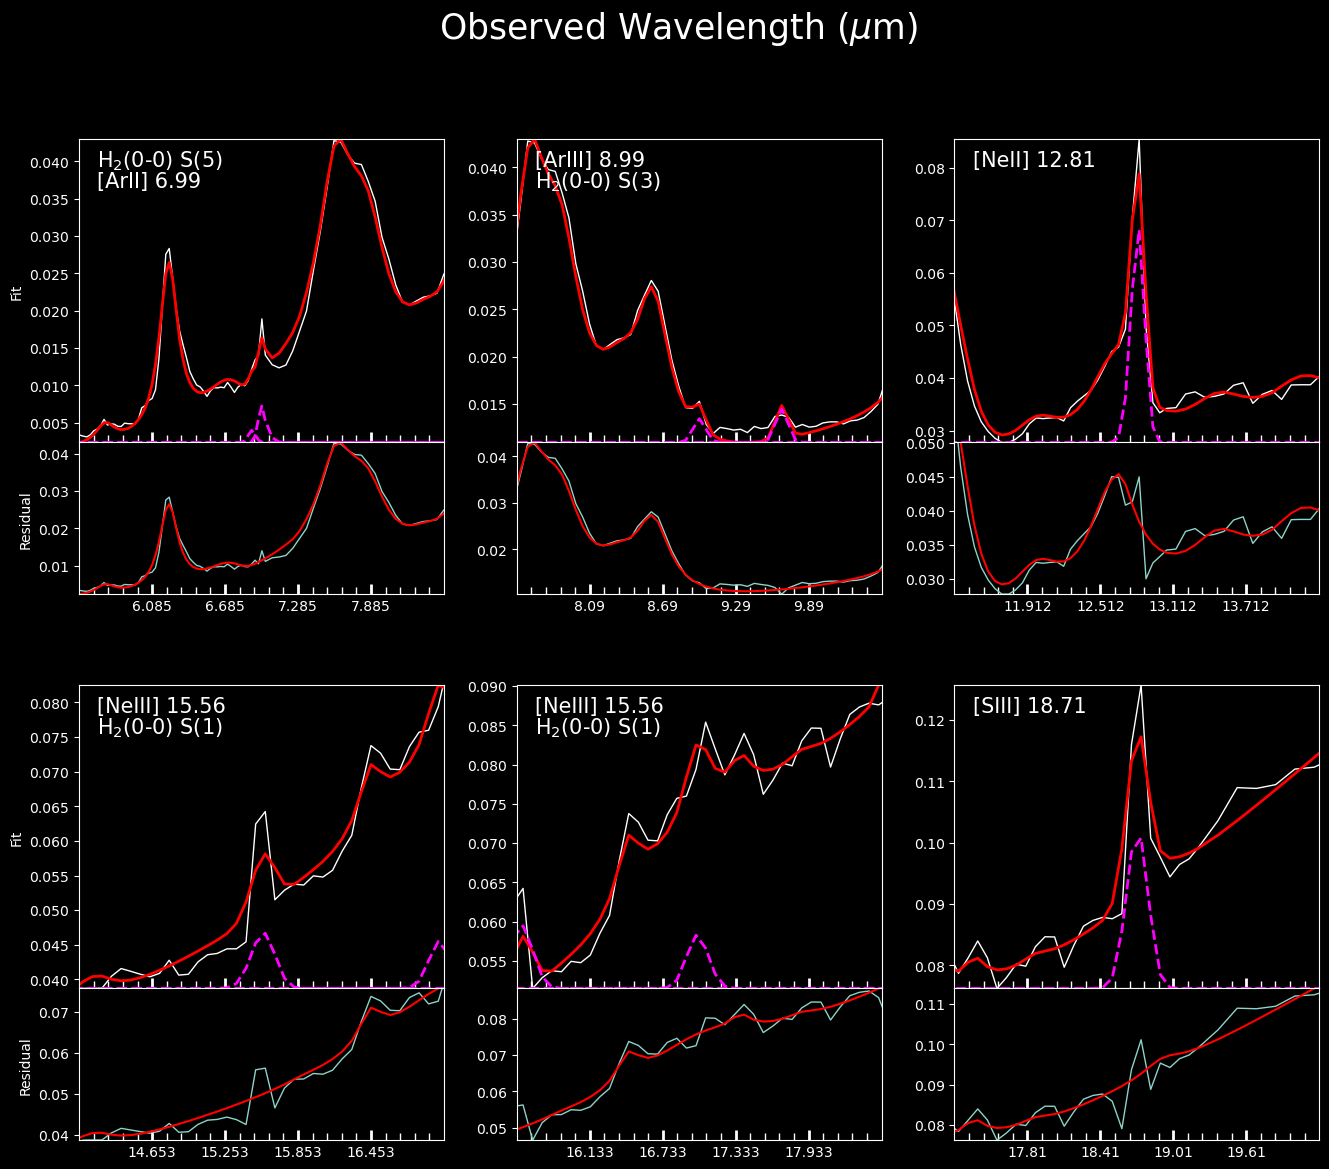

In [29]:
q3do.plot_line(q3di,plotargs=argsplotline)

The continuum plot can be changed by specifying several parameters. In this case, we have chosen to output a log/log plot of f$_\nu$ vs. wavelength.

In [30]:
argscontplot = dict()
#argscontplot['xstyle'] = 'lin'
#argscontplot['ystyle'] = 'lin'
#argscontplot['fluxunit_out'] = 'flambda'
argscontplot['mode'] = 'dark'

Run two methods. The first computes the continuum values to plot, and the second does the plotting.

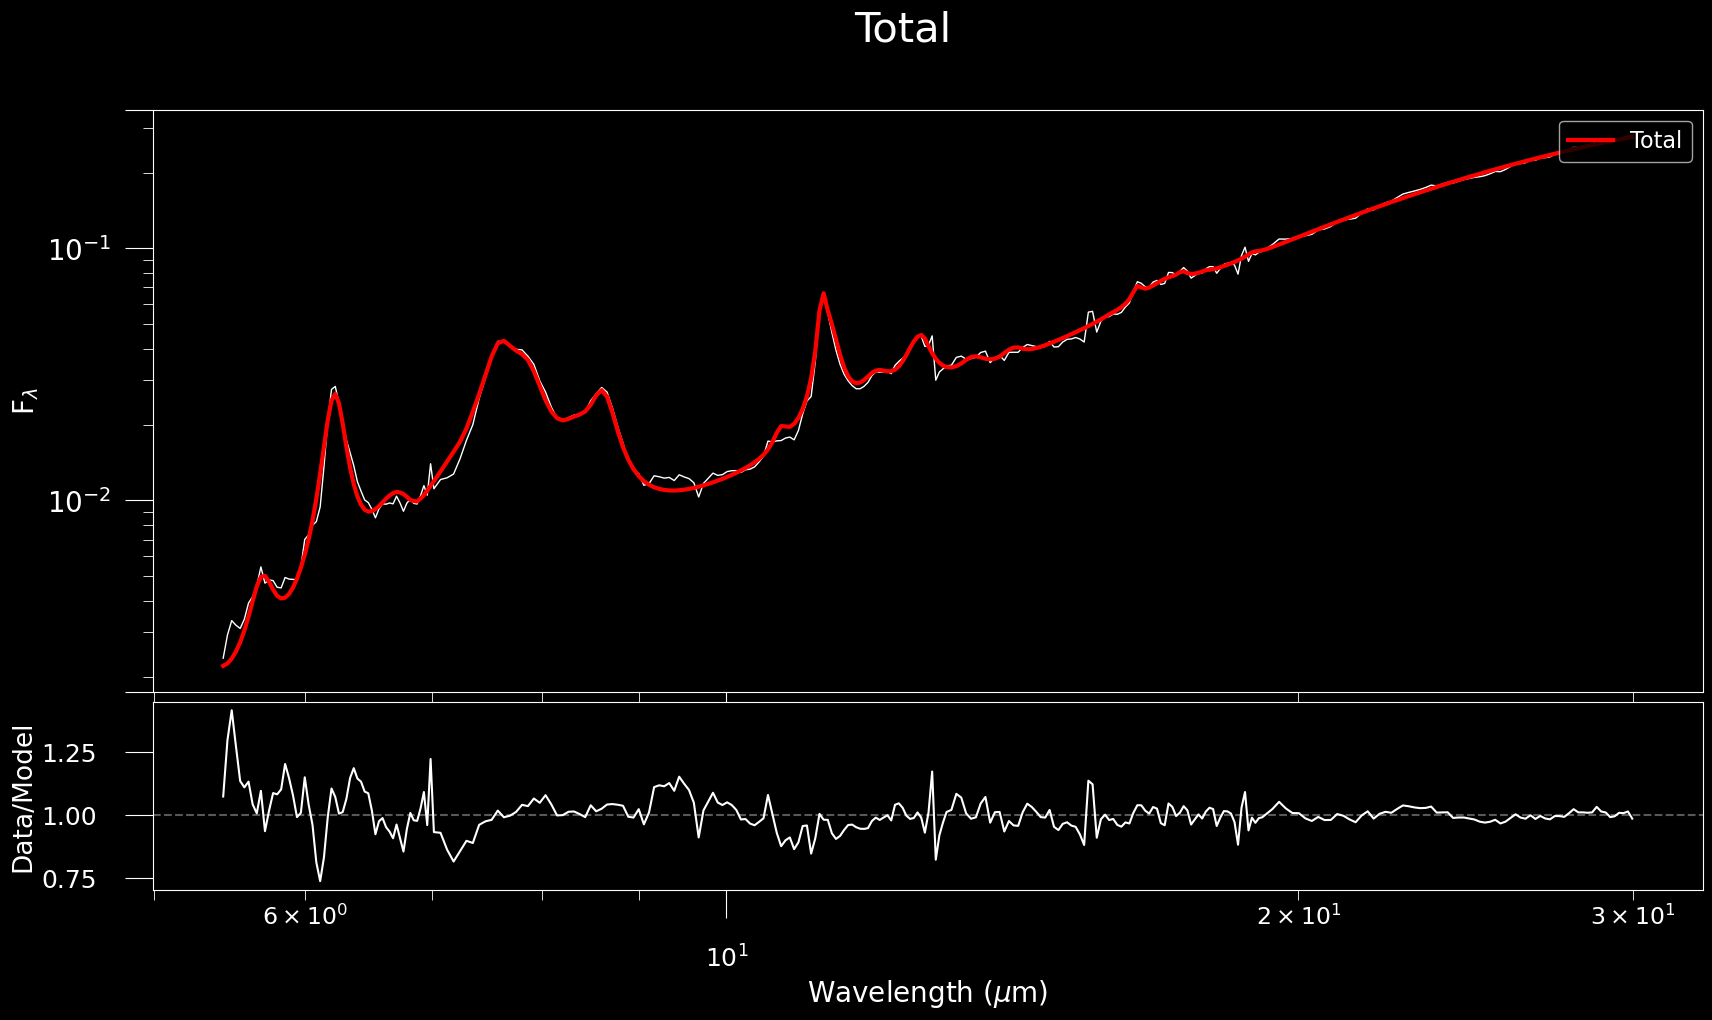

In [31]:
q3do.sepcontpars(q3di)
q3do.plot_cont(q3di, plotargs=argscontplot)